In [2]:
from __future__ import print_function
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,-8
print(env.observation_space.low)

[-2.]
[-1. -1. -8.]


In [4]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
# state = [cos, sin, angle-speed]
print(state, reward, done, info)

[-0.65612121  0.75465552  0.81729291]
[0.19525401]
[-0.70774137  0.70647162  1.41257266] -5.294751193708466 False {}


In [5]:
"""
    This method transforms cos and sin input to true degree value by arctan2 function
    
"""
def my_arctan(cos, sin):
    return np.rad2deg(np.arctan2(sin, cos))

In [6]:
from Discretization import Discretization

larry = Discretization("degree_only","Pendulum",state_space_size=(18+1, 16+1),action_space_size=17)

print(larry.state_space)
print(larry.action_space)

(array([-180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,  -20.,
          0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
        180.]), array([-8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,
        5.,  6.,  7.,  8.]))
[-2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.  ]


Regression...
25%...
50%...
75%...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


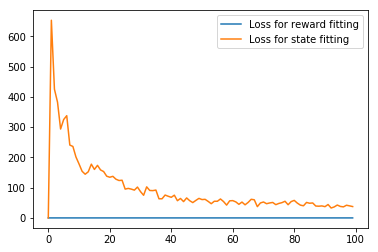

In [7]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Learning episodes / amount of samples for regression
epochs = 10000

rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

old_state = env.reset()
# Transform from 3 to 2 dim:(cos, sin, angular velocity) -> (angle, angular velocity)
old_state = np.array([my_arctan(old_state[0], old_state[1]), old_state[2]])

print("Regression...")
for i in range(epochs):
    
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    # Transform from 3 to 2 dim:(cos, sin, angular velocity) -> (angle, angular velocity)
    next_state = np.array([my_arctan(next_state[0], next_state[1]), next_state[2]])

    rtx.append(np.append(old_state ,action))
    rty.append(reward)
    stx.append(np.append(old_state,action))
    sty.append(next_state)
    
    if i%100==0: # 50 works nicely
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)
    
    old_state = np.copy(next_state)
    
    if i==int(epochs*0.25):
        print("25%...")
    if i==int(epochs*0.5):
        print("50%...")
    if i==int(epochs*0.75):
        print("75%...")

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [22]:
"""
   Value Iteration
   
   Inputs:
   disc: Discriminator object
   theta: Minimal value function difference for convergence
   gamma: Update learning rate
   
"""

# TODO: Good choice of a learning rate (gamma)

def value_iteration(disc, theta, gamma):
    
    print("Starting Value iteration:")

    value_function = np.zeros(shape=disc.state_space_size)
    policy = np.zeros(shape=disc.state_space_size)
    
    delta = theta
    
    while_loop_num = 0
    
    while delta >= theta:
        
        delta = 0
        
        print("Loop number {} ... ".format(while_loop_num), end='')
        while_loop_num += 1
        
        
        # Iterate over discrete state space
        for j, s0 in enumerate(disc.state_space[0]): # degrees
            for s1 in disc.state_space[1]: # angular velocity
                
                # Get (only positive) indexes for (possibly negative) discrete state(s)
                index = disc.map_to_index([s0, s1])
                # print(index)

                v = value_function[index[0], index[1]]

                # Iterate over all actions to get action maximizing expected reward
                amax = 2
                rmax = -100

                for a in disc.action_space:
                    # Get sufficient state and reward from regressors
                    x = np.array([s0, s1, a])
                    x = x.reshape(1,-1)
                    next_s = regressorState.predict(x).T.reshape(-1,)
                    r = regressorReward.predict(x)

                    # Discretize sufficient state
                    next_index = disc.map_to_index([next_s[0], next_s[1]])

                    # Calculate expected reward
                    # Deterministic case; we do not need probability distribution
                    expected_reward = r + gamma*value_function[next_index[0], next_index[1]]

                    if rmax < expected_reward:
                        amax = a
                        rmax = expected_reward 

                # Define value function by maximum expected reward per state
                value_function[index[0], index[1]] = rmax
                # Define policy by action achieving maximum expected reward per state
                policy[index[0], index[1]] = amax
                # Update delta
                delta = max(delta, np.abs(v-value_function[index[0], index[1]]))
            
            #if s0 == int((disc.state_space_size[0]-1)*0.25):
            #    print("25%...")
            #if s0 == int((disc.state_space_size[0]-1)*0.5):
            #   print("50%...")
            #if s0 == int((disc.state_space_size[0]-1)*0.75):
            #    print("75%...")    

        print("Delta = ", delta)
                    
                    
    print()
    print("... done!")
    return value_function, policy

value_function, policy = value_iteration(disc=larry, theta=0.001, gamma=0.1)

Starting Value iteration:
Loop number 0 ... Delta =  17.27353056906738
Loop number 1 ... Delta =  1.4495265038925567
Loop number 2 ... Delta =  0.12404846448368545
Loop number 3 ... Delta =  0.01240484644836748
Loop number 4 ... Delta =  0.0012404846448372808
Loop number 5 ... Delta =  0.00012404846448355045

... done!


In [23]:
for s0 in larry.state_space[0]:
    print("")
    for s1 in larry.state_space[1]:
        index = larry.map_to_index([s0,s1])
        print("Degree: ", s0, ", Velocity: ", s1, "Action: ", policy[index[0], index[1]])
        # print("Degree: {}, Velocity: {}, Value: {}".format(s0, s1, value_function[s0, s1]))
                    


Degree:  -180.0 , Velocity:  -8.0 Action:  -1.75
Degree:  -180.0 , Velocity:  -7.0 Action:  0.5
Degree:  -180.0 , Velocity:  -6.0 Action:  -1.0
Degree:  -180.0 , Velocity:  -5.0 Action:  0.25
Degree:  -180.0 , Velocity:  -4.0 Action:  -0.5
Degree:  -180.0 , Velocity:  -3.0 Action:  1.5
Degree:  -180.0 , Velocity:  -2.0 Action:  0.25
Degree:  -180.0 , Velocity:  -1.0 Action:  -0.75
Degree:  -180.0 , Velocity:  0.0 Action:  -2.0
Degree:  -180.0 , Velocity:  1.0 Action:  -2.0
Degree:  -180.0 , Velocity:  2.0 Action:  -2.0
Degree:  -180.0 , Velocity:  3.0 Action:  -2.0
Degree:  -180.0 , Velocity:  4.0 Action:  -2.0
Degree:  -180.0 , Velocity:  5.0 Action:  -2.0
Degree:  -180.0 , Velocity:  6.0 Action:  -2.0
Degree:  -180.0 , Velocity:  7.0 Action:  -2.0
Degree:  -180.0 , Velocity:  8.0 Action:  -2.0

Degree:  -160.0 , Velocity:  -8.0 Action:  -0.25
Degree:  -160.0 , Velocity:  -7.0 Action:  -1.5
Degree:  -160.0 , Velocity:  -6.0 Action:  -1.5
Degree:  -160.0 , Velocity:  -5.0 Action:  -1.

In [9]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""

def policy_iteration(disc, theta, gamma):        
    
    print("Policy iteration...")

    value_function = np.ones(shape=disc.state_space_size)
    policy = np.zeros(shape=disc.state_space_size)

    
    def policy_evaluation(theta, gamma):
        print()
        print("Evaluating policy")
        delta = theta
        while delta >= theta:
            delta = 0
            # Iteratate over discrete state space
            for s0 in disc.state_space[0]:
                for s1 in disc.state_space[1]:
                    for s2 in disc.state_space[2]:
                        
                        # Get index for state 
                        # The method already iterates over a discretized state space
                        # But the states need to get mapped to a positive index do to possible 'negative' states
                        index = disc.map_to_index([s0, s1, s2])
                        
                        v = value_function[index[0], index[1], index[2]]
                        
                        """
                         V(s) = Sum...p(s',r|s,pi(s))[r+gamma*V(s')]
                         
                        """
                        a = policy[index[0], index[1], index[2]]
                        
                        # input for regression
                        x = np.array([s0, s1, s2, a]).reshape(1, -1)
                        
                        # Predict next state and reward with regressors
                        next_s = regressorState.predict(x).T.reshape(-1,)
                        r = regressorReward.predict(x)      
                        
                        next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                                          
                        value_function[index[0], index[1], index[2]] = r + gamma*value_function[next_index[0],
                                                                              next_index[1], next_index[2]]
                                          
                        delta = max(delta, v - value_function[index[0], index[1], index[2]])
            print("Delta: ", delta)
    
    
    def policy_improvement(gamma):
        print()
        print("Improving policy")
        policy_stable = True
        for s0 in disc.state_space[0]:
                for s1 in disc.state_space[1]:
                    for s2 in disc.state_space[2]:
                        
                        # Indexing
                        index = disc.map_to_index([s0, s1, s2])
                        
                        old_action = policy[index[0], index[1], index[2]]
                        
                        """
                            pi(s) = argmax_a ... 
                            We do not have to care about the prob. distribution,
                            as we have a deterministic env.
                            
                        """
                        # Iterate over all actions and get the one with max. expected reward
                        amax = 2
                        rmax = -100
                        for a in disc.action_space:
                            x = np.array([s0, s1, s2, a])
                            x = x.reshape(1,-1)
                            next_s = regressorState.predict(x).T.reshape(-1,)
                            next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                            r = regressorReward.predict(x)
                            expected_reward = r + gamma*value_function[next_index[0], next_index[1], next_index[2]]
                            if rmax < expected_reward:
                                amax = a
                                rmax = expected_reward 
                        policy[index[0], index[1], index[2]] = amax # TODO
                        
                        if old_action != policy[index[0], index[1], index[2]]:
                            policy_stable = False
                            
        print("Policy stable: ", policy_stable)
        return policy_stable
        
    # Run until policy is stable
    stable_policy = False
    while not stable_policy:
        policy_evaluation(theta, gamma)
        stable_policy = policy_improvement(gamma)
    
    print()
    print("...done")
    return value_function, policy
    
# value_function, policy = policy_iteration(larry, theta=1, gamma=0.1)


Evaluating...
Episode 1 finished after 200 timesteps
Episode 2 finished after 200 timesteps
Episode 3 finished after 200 timesteps
Episode 4 finished after 200 timesteps
Episode 5 finished after 200 timesteps
Episode 6 finished after 200 timesteps
Episode 7 finished after 200 timesteps
Episode 8 finished after 200 timesteps
Episode 9 finished after 200 timesteps
Episode 10 finished after 200 timesteps
Episode 11 finished after 200 timesteps
Episode 12 finished after 200 timesteps
Episode 13 finished after 200 timesteps
Episode 14 finished after 200 timesteps
Episode 15 finished after 200 timesteps
Episode 16 finished after 200 timesteps
Episode 17 finished after 200 timesteps
Episode 18 finished after 200 timesteps
Episode 19 finished after 200 timesteps
Episode 20 finished after 200 timesteps
Episode 21 finished after 200 timesteps
Episode 22 finished after 200 timesteps
Episode 23 finished after 200 timesteps
Episode 24 finished after 200 timesteps
Episode 25 finished after 200 times

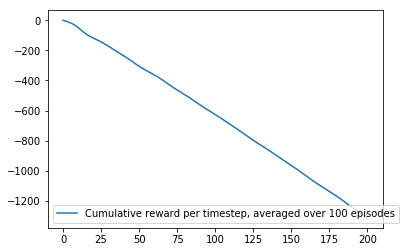

In [12]:
"""
    Evaluation stuff to see the predictions, discretizations and learned functions in action

"""
rewards_per_episode = []

episodes = 100

print("Evaluating...")

for e in range(episodes):
    
    # Discretize first state
    state = env.reset()
    state = np.array([my_arctan(state[0], state[1]), state[2]])
    index = larry.map_to_index(state)
    
    cumulative_reward = [0]
    
    for t in range(200):
        # Render environment
        env.render()

        # Do step according to policy and get observation and reward
        action = np.array([policy[index[0], index[1]]])

        #action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        state = np.array([my_arctan(observation[0], observation[1]), observation[2]])
        
        cumulative_reward.append(cumulative_reward[-1]+reward)
        
        # Discretize observed state
        index = larry.map_to_index(state)

        if done:
            print("Episode {} finished after {} timesteps".format(e+1, t+1))
            break
    
    rewards_per_episode.append(cumulative_reward)

print("...done")    

# TODO: Look at calculation of mean cumulative rewards
# Average reward over episodes
rewards = np.average(rewards_per_episode, axis=0)
        
env.close()

# Plot rewards per timestep averaged over episodes
plt.figure()
plt.plot(rewards, label='Cumulative reward per timestep, averaged over {} episodes'.format(episodes))
plt.legend()
plt.show()